In [1]:
# The code was removed by Watson Studio for sharing.

## Introduction: About the dataset and methodology

This dataset is about the boroughs in Munich, most common venues of boroughs and apartment data from the biggest apartment platform in Germany with several features such as price and living space.

**Chapter I:**  
In order to cluster the boroughs and explore them, I will use the latitude and longitude coordinates of each borough.  
I will scrape the data from the Wikipedia page of the boroughs of Munich: https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens  
First, I will convert the boroughs into their equivalent latitude and longitude values via the Google Geocode API.  
Afterwards, I will use the Foursquare API to explore the most common venue categories in each borough in Munich.  
Afterwards, this feature will be used to group the boroughs into clusters. The k-means clustering algorithm will be used to complete this task.  
Finally, the Folium library will be used to visualize the boroughs in Munich and their emerging clusters.
Afterwards, I will try to find the best rental apartment.  
Namely, in a borough that offers **supermarket** as their most common venue category and **access to public transport** as their second most common category, since these matter most to me.

**Chapter II:**  
Once the most suitable borough or boroughs have been found, I will scrape apartment listings from the immobilienscout24 platform and try to find the best apartment in my selected boroughs.   
The best apartment is an apartment that offers best value for its characteristics given, such as number of rooms, available living space and borough.  
In order to find the best apartment, I will use a regression model, namely the RANSAC method, to determine outliers and fit a regression line through all data points.  
Regression metrics, such as R_squared, will be calculated and displayed in a seaborn plot.  

As my choice of presentation, I will use my website and host the Folium frame in order to display all apartments.  
The link to my website is as follows:  https://www.greenvegan.de

# Chapter I
## Data pre-processing and exploratory data analysis
### Scraping the borough data and loading it into a Pandas dataframe

First, I will scrape the data from Wikipedia using Python and the BeautifulSoup library.  
If we take a look at the HTML code of the Wikipedia page, all the required data is stored in a **td** (table data) element of the first table.  
Therefore, the strategy is to locate this wikipedia table, then find the **td** element and then iterate through all the anchor elements that contain the borough names.  
This data will be loaded into the Pandas dataframe neighborhoods:


In [2]:
import pandas as pd

# define the dataframe columns
column_names = ['Borough', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# load libraries for scraping data
from bs4 import BeautifulSoup
import urllib.request
def make_soup(url):
    wikipage = urllib.request.urlopen(url)
    soupdata = BeautifulSoup(wikipage, "html.parser")
    return soupdata

soup = make_soup("https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens")

# find the table
table = soup.find_all('table', class_="wikitable sortable")[1]  # Only use the first table

# iterate over it
wikidatasaved = []
for item in table.findAll('tr'):
    wikidata = []
    for data in item.findAll('td'):
        wikidata.append(data.text)
    if len(wikidata) == 3:
        neighborhoods = neighborhoods.append({'Borough': wikidata[1],
                                          'Neighborhood': wikidata[2]}, ignore_index=True)

# remove newline from Neighborhood column
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].map(lambda x: str(x)[:-1])
neighborhoods['Neighborhood'].replace({'\([^)]*\)': ''}, regex=True,inplace=True)
neighborhoods

Borough  \
0                                      Altstadt-Lehel   
1                        Ludwigsvorstadt-Isarvorstadt   
2                                         Maxvorstadt   
3                                      Schwabing-West   
4                                       Au-Haidhausen   
5                                            Sendling   
6                                   Sendling-Westpark   
7                                    Schwanthalerhöhe   
8                               Neuhausen-Nymphenburg   
9                                             Moosach   
10                              Milbertshofen-Am Hart   
11                                 Schwabing-Freimann   
12                                        Bogenhausen   
13                                       Berg am Laim   
14                                     Trudering-Riem   
15                                 Ramersdorf-Perlach   
16                            Obergiesing-Fasangarten   
17                            Untergiesing-Harlaching   
18  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
19                                             Hadern   
20                                 Pasing-Obermenzing   
21                         Aubing-Lochhausen-Langwied   
22                                Allach-Untermenzing   
23                             Feldmoching-Hasenbergl   
24                                               Laim   

                                         Neighborhood  
0   Graggenau , Angerviertel , Hackenviertel , Kre...  
1   Gärtnerplatz , Deutsches Museum , Glockenbach ...  
2   Königsplatz , Augustenstraße , St. Benno , Mar...  
3   Neuschwabing , Am Luitpoldpark , Schwere-Reite...  
4   Maximilianeum , Steinhausen , Haidhausen-Nord ...  
5                    Untersendling , Sendlinger Feld   
6   Mittersendling , Land in Sonne , Am Waldfriedhof   
7                         Westend , Schwanthalerhöhe   
8   Neuhausen , Nymphenburg , Oberwiesenfeld , St....  
9                      Alt Moosach , Moosach-Bahnhof   
10           Am Hart , Am Riesenfeld , Milbertshofen   
11  Freimann , Obere Isarau , Alte Heide-Hirschau ...  
12  Oberföhring , Johanneskirchen , Herzogpark , E...  
13        Echarding , Josephsburg , Berg am Laim Ost   
14  Trudering-Riem , Messestadt Riem , Gartenstadt...  
15  Ramersdorf , Balanstraße-West , Altperlach , N...  
16                          Obergiesing , Südgiesing   
17  Untergiesing , Siebenbrunn , Giesing , Neuharl...  
18  Thalkirchen , Obersendling , Forstenried , Für...  
19                 Blumenau , Neuhadern , Großhadern   
20     Neupasing , Am Westbad , Pasing , Obermenzing   
21     Altaubing , Aubing-Süd , Lochhausen , Freiham   
22             Industriebezirk , Untermenzing-Allach   
23  Feldmoching , Hasenbergl-Lerchenau Ost , Ludwi...  
24                          Friedenheim , St. Ulrich

In [3]:

import requests 
import json

# define the dataframe columns
column_names = ['Latitude', 'Longitude'] 

# instantiate the dataframe
locations = pd.DataFrame(columns=column_names)

apiKey = "REMOVED"
for index, row in neighborhoods.iterrows():
    address = row['Borough'] + ', Munich'
    r = requests.get("https://maps.googleapis.com/maps/api/geocode/json?address="+ address +"&key="+ apiKey)
    location = json.loads(r.content.decode('utf-8'))
    if location['status'] != 'ZERO_RESULTS':
        locations = locations.append({'Latitude': location['results'][0]['geometry']['location']['lat'],
                                          'Longitude': location['results'][0]['geometry']['location']['lng'],}, ignore_index=True)
neighborhoods = neighborhoods.join(locations)
neighborhoods.head()

Borough  \
0                Altstadt-Lehel   
1  Ludwigsvorstadt-Isarvorstadt   
2                   Maxvorstadt   
3                Schwabing-West   
4                 Au-Haidhausen   

                                        Neighborhood   Latitude  Longitude  
0  Graggenau , Angerviertel , Hackenviertel , Kre...  48.143054  11.588587  
1  Gärtnerplatz , Deutsches Museum , Glockenbach ...  48.126250  11.558295  
2  Königsplatz , Augustenstraße , St. Benno , Mar...  48.149976  11.573622  
3  Neuschwabing , Am Luitpoldpark , Schwere-Reite...  48.167852  11.571096  
4  Maximilianeum , Steinhausen , Haidhausen-Nord ...  48.128592  11.593926

In [4]:
print('The dataframe has {} boroughs and {} location data.'.format(
        len(neighborhoods['Borough'].unique()), len(neighborhoods['Latitude'].unique())
    )
)

The dataframe has 25 boroughs and 25 location data.


### Using the Foursquare API to explore and segment boroughs

Next, we are going to start utilizing the Foursquare API to explore the Boroughs and segment them.  
Let's start off with defining the Foursquare credentials and the version:


In [5]:


CLIENT_ID = 'REMOVED' # your Foursquare ID
CLIENT_SECRET = 'REMOVED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's take a look at the first Borough in our Munich dataframe and get its coordinates:

In [6]:
neighborhoods.loc[0, 'Borough']


'Altstadt-Lehel'

In [7]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Altstadt-Lehel are 48.1430545, 11.5885872.


Now, let's use the Foursquare API to get the top 100 venues that are within a radius of 1000 meters from the Boroughs center coordinates:

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
results # display results

{'meta': {'code': 200, 'requestId': '5bf198599fb6b75dc65ee0f0'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4c1369ec7f7f2d7f9b01df68-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/surfspot_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1e3941735',
         'name': 'Surf Spot',
         'pluralName': 'Surf Spots',
         'primary': True,
         'shortName': 'Surf Spot'}],
       'id': '4c1369ec7f7f2d7f9b01df68',
       'location': {'address': 'Prinzregentenstr. 1',
        'cc': 'DE',
        'city': 'München',
        'country': 'Deutschland',
        'crossStreet': 'Lerchenfeldstr.',
        'distance': 68,
        'formattedAddress': ['Prinzregentenstr. 1 (Lerchenfeldstr.)',
         '80538 München',
         'Deutschland'],
   

Apparently, there are 111 venues in a radius of 1000 meters.  
Let's see what kind of venues have been found by casting the JSON to a Pandas dataframe:

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [10]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON data into a Pandas dataframe

# filter columns 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name         categories        lat        lng
0        Eisbachwelle          Surf Spot  48.143342  11.587775
1    Fräulein Grüneis        Snack Place  48.143715  11.589003
2     Die Goldene Bar       Cocktail Bar  48.144107  11.586004
3  Liebighof im Lehel  German Restaurant  48.140738  11.590670
4     SEITZ Trattoria  Trattoria/Osteria  48.141419  11.584902

### Exploring all boroughs in Munich

After exploring one single Borough, let's create a function to do the same process to all boroughs in Munich:


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
munich_venues = getNearbyVenues(names=neighborhoods['Borough'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Altstadt-Lehel
Ludwigsvorstadt-Isarvorstadt
Maxvorstadt
Schwabing-West
Au-Haidhausen
Sendling
Sendling-Westpark
Schwanthalerhöhe
Neuhausen-Nymphenburg
Moosach
Milbertshofen-Am Hart
Schwabing-Freimann
Bogenhausen
Berg am Laim
Trudering-Riem
Ramersdorf-Perlach
Obergiesing-Fasangarten
Untergiesing-Harlaching
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
Hadern
Pasing-Obermenzing
Aubing-Lochhausen-Langwied
Allach-Untermenzing
Feldmoching-Hasenbergl
Laim


Let's check the size of the dataframe and the top 5 rows:

In [13]:
print(munich_venues.shape)
munich_venues.head()

(1202, 7)


Borough  Borough Latitude  Borough Longitude               Venue  \
0  Altstadt-Lehel         48.143054          11.588587        Eisbachwelle   
1  Altstadt-Lehel         48.143054          11.588587    Fräulein Grüneis   
2  Altstadt-Lehel         48.143054          11.588587     Die Goldene Bar   
3  Altstadt-Lehel         48.143054          11.588587  Liebighof im Lehel   
4  Altstadt-Lehel         48.143054          11.588587     SEITZ Trattoria   

   Venue Latitude  Venue Longitude     Venue Category  
0       48.143342        11.587775          Surf Spot  
1       48.143715        11.589003        Snack Place  
2       48.144107        11.586004       Cocktail Bar  
3       48.140738        11.590670  German Restaurant  
4       48.141419        11.584902  Trattoria/Osteria

Let's see how many venues have been returned for each Borough given the radius of 1000 meters and the venue limit of 100:


In [14]:
munich_venues.groupby('Borough')['Borough'].count()

Borough
Allach-Untermenzing                                        20
Altstadt-Lehel                                            100
Au-Haidhausen                                             100
Aubing-Lochhausen-Langwied                                 13
Berg am Laim                                               18
Bogenhausen                                                12
Feldmoching-Hasenbergl                                      2
Hadern                                                     28
Laim                                                       53
Ludwigsvorstadt-Isarvorstadt                               82
Maxvorstadt                                               100
Milbertshofen-Am Hart                                      19
Moosach                                                    27
Neuhausen-Nymphenburg                                      61
Obergiesing-Fasangarten                                    41
Pasing-Obermenzing                                         63


Let's see how many unique venue categories have been collected in this dataframe:

In [15]:
print('There are {} uniques categories.'.format(len(munich_venues['Venue Category'].unique())))

There are 205 uniques categories.


## Analyzing each borough

Now, each venue in a borough will be sorted into its respective category.  
Afterwards, the mean frequency of occurence of a respective category in a borough will be displayed.  
In essence, let's find out what kind of venues there are in each borough and how frequent these categories of venues are in regards to the total of venues.  
For example, if there are 5 restaurants with the category Italian restaurant in our collection of 100 venues, the category Italian restaurant will be assigned the value 0.05.  

First, let's use one-hot encoding to convert the categorical venue category to a binary classifier column for each venue category:

In [16]:
# one hot encoding
munich_onehot = pd.get_dummies(munich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
munich_onehot['Borough'] = munich_venues['Borough']

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot



Borough  Accessories Store  Afghan Restaurant  \
0     Altstadt-Lehel                  0                  0   
1     Altstadt-Lehel                  0                  0   
2     Altstadt-Lehel                  0                  0   
3     Altstadt-Lehel                  0                  0   
4     Altstadt-Lehel                  0                  0   
5     Altstadt-Lehel                  0                  0   
6     Altstadt-Lehel                  0                  0   
7     Altstadt-Lehel                  0                  0   
8     Altstadt-Lehel                  0                  0   
9     Altstadt-Lehel                  0                  0   
10    Altstadt-Lehel                  0                  0   
11    Altstadt-Lehel                  0                  0   
12    Altstadt-Lehel                  0                  0   
13    Altstadt-Lehel                  0                  0   
14    Altstadt-Lehel                  0                  0   
15    Altstadt-Lehel                  0                  0   
16    Altstadt-Lehel                  0                  0   
17    Altstadt-Lehel                  0                  0   
18    Altstadt-Lehel                  0                  0   
19    Altstadt-Lehel                  0                  0   
20    Altstadt-Lehel                  0                  0   
21    Altstadt-Lehel                  0                  0   
22    Altstadt-Lehel                  0                  0   
23    Altstadt-Lehel                  0                  0   
24    Altstadt-Lehel                  0                  0   
25    Altstadt-Lehel                  0                  0   
26    Altstadt-Lehel                  0                  0   
27    Altstadt-Lehel                  0                  0   
28    Altstadt-Lehel                  0                  0   
29    Altstadt-Lehel                  0                  0   
...              ...                ...                ...   
1172            Laim                  0                  0   
1173            Laim                  0                  0   
1174            Laim                  0                  0   
1175            Laim                  0                  0   
1176            Laim                  0                  0   
1177            Laim                  0                  0   
1178            Laim                  0                  0   
1179            Laim                  0                  0   
1180            Laim                  0                  0   
1181            Laim                  0                  0   
1182            Laim                  0                  0   
1183            Laim                  0                  0   
1184            Laim                  0                  0   
1185            Laim                  0                  0   
1186            Laim                  0                  0   
1187            Laim                  0                  0   
1188            Laim                  0                  0   
1189            Laim                  0                  0   
1190            Laim                  0                  0   
1191            Laim                  0                  0   
1192            Laim                  0                  0   
1193            Laim                  0                  0   
1194            Laim                  0                  0   
1195            Laim                  0                  0   
1196            Laim                  0                  0   
1197            Laim                  0                  0   
1198            Laim                  0                  0   
1199            Laim                  0                  0   
1200            Laim                  0                  0   
1201            Laim                  0                  0   

      African Restaurant  American Restaurant  Aquarium  Art Gallery  \
0                      0                    0         0            0   
1                      0

Let's see whether we have all 205 categories in the dataframe:

In [17]:
munich_onehot.shape

(1202, 206)

Good.  
Let's group the rows by borough and by taking the mean of the frequency of occurrence of each category as discussed in our strategy:

In [18]:
munich_grouped = munich_onehot.groupby('Borough').mean().reset_index()
munich_grouped

Borough  Accessories Store  \
0                                 Allach-Untermenzing           0.000000   
1                                      Altstadt-Lehel           0.000000   
2                                       Au-Haidhausen           0.000000   
3                          Aubing-Lochhausen-Langwied           0.000000   
4                                        Berg am Laim           0.055556   
5                                         Bogenhausen           0.000000   
6                              Feldmoching-Hasenbergl           0.000000   
7                                              Hadern           0.000000   
8                                                Laim           0.000000   
9                        Ludwigsvorstadt-Isarvorstadt           0.000000   
10                                        Maxvorstadt           0.000000   
11                              Milbertshofen-Am Hart           0.000000   
12                                            Moosach           0.000000   
13                              Neuhausen-Nymphenburg           0.000000   
14                            Obergiesing-Fasangarten           0.000000   
15                                 Pasing-Obermenzing           0.000000   
16                                 Ramersdorf-Perlach           0.000000   
17                                 Schwabing-Freimann           0.000000   
18                                     Schwabing-West           0.000000   
19                                   Schwanthalerhöhe           0.000000   
20                                           Sendling           0.000000   
21                                  Sendling-Westpark           0.000000   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...           0.000000   
23                                     Trudering-Riem           0.000000   
24                            Untergiesing-Harlaching           0.000000   

    Afghan Restaurant  African Restaurant  American Restaurant  Aquarium  \
0                0.00            0.000000             0.000000  0.000000   
1                0.00            0.000000             0.010000  0.000000   
2                0.01            0.000000             0.000000  0.000000   
3                0.00            0.000000             0.000000  0.000000   
4                0.00            0.000000             0.000000  0.000000   
5                0.00            0.000000             0.000000  0.000000   
6                0.00            0.000000             0.000000  0.000000   
7                0.00            0.000000             0.000000  0.000000   
8                0.00            0.000000             0.018868  0.000000   
9                0.00            0.012195             0.000000  0.000000   
10               0.00            0.000000             0.000000  0.000000   
11               0.00            0.000000             0.000000  0.000000   
12               0.00            0.000000             0.037037  0.000000   
13               0.00            0.000000             0.000000  0.000000   
14               0.00            0.000000             0.000000  0.000000   
15               0.00            0.000000             0.000000  0.000000   
16               0.00            0.000000             0.000000  0.000000   
17               0.00            0.000000             0.000000  0.000000   
18               0.01            0.000000             0.000000  0.000000   
19               0.00            0.000000             0.010000  0.000000   
20               0.00            0.000000             0.000000  0.000000   
21               0.00            0.000000             0.000000  0.000000   
22               0.00            0.000000             0.000000  0.000000   
23               0.00            0.000000             0.000000  0.000000   
24               0.00            0.000000             0.000000  0.027027   

    Art Gallery  Art Museum  Asian Restaurant  Athletics & Sports  \
0          0.00        

Let's find out what the top 5 most common venues for each borough in Munich are:

In [19]:
num_top_venues = 5

for hood in munich_grouped['Borough']:
    print("----"+hood+"----")
    temp = munich_grouped[munich_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allach-Untermenzing----
                 venue  freq
0          Supermarket  0.15
1  Sporting Goods Shop  0.15
2            Drugstore  0.10
3             Bus Stop  0.10
4               Bakery  0.10


----Altstadt-Lehel----
               venue  freq
0  German Restaurant  0.10
1               Café  0.09
2              Plaza  0.07
3       Cocktail Bar  0.06
4           Boutique  0.06


----Au-Haidhausen----
                venue  freq
0                Café  0.09
1  Italian Restaurant  0.07
2               Plaza  0.06
3   German Restaurant  0.05
4   French Restaurant  0.04


----Aubing-Lochhausen-Langwied----
          venue  freq
0        Bakery  0.23
1   Supermarket  0.15
2  Soccer Field  0.15
3   Post Office  0.08
4         Hotel  0.08


----Berg am Laim----
               venue  freq
0      Metro Station  0.11
1              Hotel  0.11
2  Accessories Store  0.06
3               Bank  0.06
4  German Restaurant  0.06


----Bogenhausen----
                venue  freq
0  Italian Rest

Great.  
Let's put this knowledge into a new dataframe with each borough and the top 10 most common venues.  
First, let's write a function to sort the venues in descending order:

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = munich_grouped['Borough']

for ind in np.arange(munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Borough 1st Most Common Venue  \
0                                 Allach-Untermenzing   Sporting Goods Shop   
1                                      Altstadt-Lehel     German Restaurant   
2                                       Au-Haidhausen                  Café   
3                          Aubing-Lochhausen-Langwied                Bakery   
4                                        Berg am Laim                 Hotel   
5                                         Bogenhausen    Italian Restaurant   
6                              Feldmoching-Hasenbergl    Italian Restaurant   
7                                              Hadern              Bus Stop   
8                                                Laim           Supermarket   
9                        Ludwigsvorstadt-Isarvorstadt                  Café   
10                                        Maxvorstadt                  Café   
11                              Milbertshofen-Am Hart              Bus Stop   
12                                            Moosach                Bakery   
13                              Neuhausen-Nymphenburg                Bakery   
14                            Obergiesing-Fasangarten           Supermarket   
15                                 Pasing-Obermenzing                  Café   
16                                 Ramersdorf-Perlach           Supermarket   
17                                 Schwabing-Freimann      Greek Restaurant   
18                                     Schwabing-West    Italian Restaurant   
19                                   Schwanthalerhöhe    Italian Restaurant   
20                                           Sendling                 Hotel   
21                                  Sendling-Westpark           Supermarket   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...              Bus Stop   
23                                     Trudering-Riem    Italian Restaurant   
24                            Untergiesing-Harlaching           Zoo Exhibit   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0            Supermarket             Drugstore              Bus Stop   
1                   Café                 Plaza              Boutique   
2     Italian Restaurant                 Plaza     German Restaurant   
3           Soccer Field           Supermarket  Gym / Fitness Center   
4          Metro Station     Accessories Store          Tram Station   
5              Drugstore           Supermarket      Greek Restaurant   
6                   Lake           Zoo Exhibit           Event Space   
7          Metro Station           Supermarket     German Restaurant   
8               Bus Stop             Gastropub                Bakery   
9     Italian Restaurant                   Bar     German Restaurant   
10                   Bar    Italian Restaurant            Art Museum   
11           Supermarket         Metro Station      Greek Restaurant   
12             Drugstore           Supermarket                 Hotel   
13    Italian Restaurant          Tram Station                 Plaza   
14             Drugstore                 Hotel                  Park   
15             Drugstore    Italian Restaurant     German Restaurant   
16        Clothing Store      Asian Restaurant     German Restaurant   
17          Concert Hall     Food & Drink Shop                   Pub   
18                 Plaza           Supermarket      Greek Restaurant   
19                 Hotel                  Café      Doner Restaurant   
20    Italian Restaurant     German Restaurant              Bus Stop   
21              Bus Stop                Garden             Drugstore   
22                 Hotel     German Restaurant                  Bank   
23                  Café                 Hotel     German Restaurant   
24          Tram Station           Supermarket          Soccer Field   

    5th Most Common Venue  6th Most Common Venue  7th Most Common Venue  \
0                  Bakery      German Resta

## Modeling: K-means
### Cluster the boroughs in Munich

Let's cluster the boroughs into 2 cluster because of the limited datapoints.  
The k-means algorithm will be used for this:


In [22]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 2

munich_grouped_clustering = munich_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the clusters, as well as the top 10 venues for each borough.

In [23]:
munich_merged = neighborhoods

# add clustering labels
munich_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
munich_merged = munich_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

munich_merged.head() # check the last columns!

Borough  \
0                Altstadt-Lehel   
1  Ludwigsvorstadt-Isarvorstadt   
2                   Maxvorstadt   
3                Schwabing-West   
4                 Au-Haidhausen   

                                        Neighborhood   Latitude  Longitude  \
0  Graggenau , Angerviertel , Hackenviertel , Kre...  48.143054  11.588587   
1  Gärtnerplatz , Deutsches Museum , Glockenbach ...  48.126250  11.558295   
2  Königsplatz , Augustenstraße , St. Benno , Mar...  48.149976  11.573622   
3  Neuschwabing , Am Luitpoldpark , Schwere-Reite...  48.167852  11.571096   
4  Maximilianeum , Steinhausen , Haidhausen-Nord ...  48.128592  11.593926   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0     German Restaurant                  Café   
1               0                  Café    Italian Restaurant   
2               0                  Café                   Bar   
3               0    Italian Restaurant                 Plaza   
4               0                  Café    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0                 Plaza              Boutique           Cocktail Bar   
1                   Bar     German Restaurant         Ice Cream Shop   
2    Italian Restaurant            Art Museum                  Plaza   
3           Supermarket      Greek Restaurant  Vietnamese Restaurant   
4                 Plaza     German Restaurant      French Restaurant   

   6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0                  Hotel    Bavarian Restaurant    Italian Restaurant   
1                  Plaza  Vietnamese Restaurant   Bavarian Restaurant   
2  Vietnamese Restaurant         Ice Cream Shop     German Restaurant   
3                   Café        Thai Restaurant                   Bar   
4      Indian Restaurant                    Bar                 Beach   

      9th Most Common Venue 10th Most Common Venue  
0                   Theater             Art Museum  
1                 Nightclub           Cocktail Bar  
2  Mediterranean Restaurant           Cocktail Bar  
3         Indian Restaurant              Drugstore  
4            Ice Cream Shop     Turkish Restaurant

### Visualization of the boroughs in Munich, segmented into k = 2 clusters
The geopy geocode function will be quickly used get the central coordinates of Munich, so that we can spread the clustered boroughs evenly around it later:

In [24]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Munich'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Munich are {} latitude and {} longitude.'.format(latitude, longitude))

The geograpical coordinates of Munich are 48.1371079 latitude and 11.5753822 longitude.


In [25]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(munich_merged['Latitude'], munich_merged['Longitude'], munich_merged['Borough'], munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


### Discussion of borough clustering
Apparently, one main cluster emerged and one outlier.  
Let's figure out what makes this one borough be an outlier.  
On first notice, this outlier borough "Sendling-Westpark" has three unusual most common venue categories: **Garden**, **Rental Car Location**, **Brewery**.  
Since the k-means clustering algorithm calculates the Euclidian distance to the nearest mean category, this clustering is not surprising.

Next, I will find the "best" rental apartment in a borough that has many supermarkets and good public transport access.  
If we take a look at the dataframe, the following boroughs will be selected: Hadern, Laim, Milbertshofen-Am Hart, Sendling-Westpark.

# Chapter II
## Data pre-processing and exploratory data analysis

### Scrape apartments from immoscout24
Let's scrape all available apartments from immobilienscout24.de

First, let's load all necessary libraries and modules and define a function for switching user agents, so that our scraping attempt doesn't get blocked.

In [26]:
from bs4 import BeautifulSoup
import json
import urllib.request as urllib2
import random
from random import choice
import time

In [27]:
# urlquery from Achim Tack. Thank you!
# https://github.com/ATack/GoogleTrafficParser/blob/master/google_traffic_parser.py

def urlquery(url):
    # function cycles randomly through different user agents and time intervals to simulate more natural queries
    try:
        sleeptime = float(random.randint(1,6))/5
        time.sleep(sleeptime)

        agents = ['Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17',
        'Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0',
        'Opera/12.80 (Windows NT 5.1; U; en) Presto/2.10.289 Version/12.02',
        'Mozilla/4.0 (compatible; MSIE 5.5; Windows NT)',
        'Mozilla/3.0',
        'Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420+ (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3',
        'Mozilla/5.0 (Linux; U; Android 0.5; en-us) AppleWebKit/522+ (KHTML, like Gecko) Safari/419.3',
        'Opera/9.00 (Windows NT 5.1; U; en)']

        agent = choice(agents)
        opener = urllib2.build_opener()
        opener.addheaders = [('User-agent', agent)]

        html = opener.open(url).read()
        time.sleep(sleeptime)
        
        return html

    except Exception as e:
        print('Something went wrong with Crawling:\n%s' % e)


Let's define a parser function for the apartment search results, namely to store the JSON string in a Python dictionary immo_json:

In [28]:
# immoscoutparser from balzer24. Thank you!
# https://github.com/balzer82/immoscraper/blob/master/immoscraper.py

def immoscout24parser(url):
    
    ''' Parser takes search results from Immoscout24.de'''
    
    try:
        soup = BeautifulSoup(urlquery(url), 'html.parser')
        scripts = soup.findAll('script')
        for script in scripts:
            #print script.text.strip()
            if 'IS24.resultList' in script.text.strip():
                s = script.string.split('\n')
                for line in s:
                    #print('\n\n\'%s\'' % line)
                    if line.strip().startswith('resultListModel'):
                        resultListModel = line.strip('resultListModel: ')
                        immo_json = json.loads(resultListModel[:-1])

                        searchResponseModel = immo_json[u'searchResponseModel']
                        resultlist_json = searchResponseModel[u'resultlist.resultlist']
                        
                        return resultlist_json

    except Exception as e:
        print("Error in immoscout24 parser: %s" % e)

Now, the most important part.  
A loop that loops through all apartments or houses, depending on choice, and records several features such as price, living space and number of rooms.

In [29]:
# from balzer24. Thank you!
# https://github.com/balzer82/immoscraper/blob/master/immoscraper.py

# ## Main Loop
# Loops through apartments and houses, either for sale or for rent



immos = {}

b = 'Bayern' # county
s = 'Muenchen' # city
k = 'Wohnung' # Wohnung or Haus
w = 'Miete' # Miete or Kauf

page = 0
print('Searching %s / %s' % (k, w))

while True:
    page+=1
    url = 'http://www.immobilienscout24.de/Suche/S-T/P-%s/%s-%s/%s/%s?pagerReporting=true' % (page, k, w, b, s)

    # Because of some timeout or immoscout24.de errors,
    # we try until it works \o/
    resultlist_json = None
    while resultlist_json is None:
        try:
            resultlist_json = immoscout24parser(url)
            numberOfPages = int(resultlist_json[u'paging'][u'numberOfPages'])
            pageNumber = int(resultlist_json[u'paging'][u'pageNumber'])
        except:
            pass

    if page>numberOfPages:
        break

    # Get the data
    for resultlistEntry in resultlist_json['resultlistEntries'][0][u'resultlistEntry']:
        realEstate_json = resultlistEntry[u'resultlist.realEstate']
        
        realEstate = {}

        realEstate[u'Miete/Kauf'] = w
        realEstate[u'Haus/Wohnung'] = k

        realEstate['address'] = realEstate_json['address']['description']['text']
        realEstate['city'] = realEstate_json['address']['city']
        realEstate['postcode'] = realEstate_json['address']['postcode']
        realEstate['quarter'] = realEstate_json['address']['quarter']
        try:
            realEstate['lat'] = realEstate_json['address'][u'wgs84Coordinate']['latitude']
            realEstate['lon'] = realEstate_json['address'][u'wgs84Coordinate']['longitude']
        except:
            realEstate['lat'] = None
            realEstate['lon'] = None
            
        realEstate['title'] = realEstate_json['title']

        realEstate['numberOfRooms'] = realEstate_json['numberOfRooms']
        realEstate['livingSpace'] = realEstate_json['livingSpace']
        
        if k=='Wohnung':
            realEstate['balcony'] = realEstate_json['balcony']
            realEstate['builtInKitchen'] = realEstate_json['builtInKitchen']
            realEstate['garden'] = realEstate_json['garden']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
        elif k=='Haus':
            realEstate['isBarrierFree'] = realEstate_json['isBarrierFree']
            realEstate['cellar'] = realEstate_json['cellar']
            realEstate['plotArea'] = realEstate_json['plotArea']
            realEstate['price'] = realEstate_json['price']['value']
            realEstate['privateOffer'] = realEstate_json['privateOffer']
        
        realEstate['floorplan'] = realEstate_json['floorplan']
        realEstate['from'] = realEstate_json['companyWideCustomerId']
        realEstate['ID'] = realEstate_json[u'@id']
        realEstate['url'] = u'https://www.immobilienscout24.de/expose/%s' % realEstate['ID']

        immos[realEstate['ID']] = realEstate

    print('Scrape Page %i/%i (%i properties %s as %s found)' % (page, numberOfPages, len(immos), k, w))

Searching Wohnung / Miete
Scrape Page 1/73 (20 properties Wohnung as Miete found)
Scrape Page 2/73 (40 properties Wohnung as Miete found)
Scrape Page 3/73 (60 properties Wohnung as Miete found)
Scrape Page 4/73 (80 properties Wohnung as Miete found)
Scrape Page 5/73 (100 properties Wohnung as Miete found)
Scrape Page 6/73 (120 properties Wohnung as Miete found)
Scrape Page 7/73 (140 properties Wohnung as Miete found)
Scrape Page 8/73 (160 properties Wohnung as Miete found)
Scrape Page 9/73 (180 properties Wohnung as Miete found)
Scrape Page 10/73 (200 properties Wohnung as Miete found)
Scrape Page 11/73 (220 properties Wohnung as Miete found)
Scrape Page 12/73 (240 properties Wohnung as Miete found)
Scrape Page 13/73 (260 properties Wohnung as Miete found)
Scrape Page 14/73 (280 properties Wohnung as Miete found)
Scrape Page 15/73 (300 properties Wohnung as Miete found)
Scrape Page 16/73 (320 properties Wohnung as Miete found)
Scrape Page 17/73 (340 properties Wohnung as Miete found)
S

In [30]:
print("Scraped %i flats for rent." % len(immos))

Scraped 1449 flats for rent.


In [31]:
from datetime import datetime
timestamp = datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')


Let's load the scraped data into a Pandas dataframe:

In [32]:
import pandas as pd

df = pd.DataFrame(immos).T
df.index.name = 'ID'

In [33]:
df.head()

Haus/Wohnung         ID Miete/Kauf  \
ID                                             
100119360      Wohnung  100119360      Miete   
100283941      Wohnung  100283941      Miete   
101122542      Wohnung  101122542      Miete   
101191523      Wohnung  101191523      Miete   
101220861      Wohnung  101220861      Miete   

                                                  address balcony  \
ID                                                                  
100119360            Revalerstr. 10, Bogenhausen, München    true   
100283941  Prinzregentenstrasse 144, Bogenhausen, München    true   
101122542                             Ramersdorf, München    true   
101191523                    Viebigplatz 4, Laim, München    true   
101220861               Siegesstr. 12, Schwabing, München   false   

          builtInKitchen     city floorplan  \
ID                                            
100119360           true  München     false   
100283941           true  München      true   
101122542           true  München     false   
101191523           true  München      true   
101220861           true  München     false   

                                               from garden      lat  \
ID                                                                    
100119360                               001.1021990  false  48.1443   
100283941                                001.452483  false  48.1379   
101122542                              001.15677420  false     None   
101191523                               001.5784406  false  48.1285   
101220861  009.9996fc23-7f74-443b-97e8-e4db5ea962bd  false  48.1595   

          livingSpace      lon numberOfRooms postcode price privateOffer  \
ID                                                                         
100119360          41  11.6265           1.5    81677  1130         true   
100283941          71  11.6177             3    81675  1650        false   
101122542          84     None             3    81669  1400         true   
101191523        35.6  11.5084             1    80686   720         true   
101220861          25  11.5877           1.5    80802   860         true   

               quarter                                              title  \
ID                                                                          
100119360  Bogenhausen  Modern möblierte 1,5 Zimmer Wohnung mit Terras...   
100283941  Bogenhausen  Schöne möblierte 3-Zimmerwohnung in Bogenhause...   
101122542   Ramersdorf            ! Neubau - Exklusive 3-Zimmer-Wohnung !   
101191523         Laim  Ruhiges, freundliches, helles Apartment, Münch...   
101220861    Schwabing  1 1/2 Zi-Apartment mit TG-Stellplatz in M-Schw...   

                                                         url  
ID                                                            
100119360  https://www.immobilienscout24.de/expose/100119360  
100283941  https://www.immobilienscout24.de/expose/100283941  
101122542  https://www.immobilienscout24.de/expose/101122542  
101191523  https://www.immobilienscout24.de/expose/101191523  
101220861  https://www.immobilienscout24.de/expose/101220861

Let's check the columns regarding available features:

In [34]:
df.columns

Index(['Haus/Wohnung', 'ID', 'Miete/Kauf', 'address', 'balcony',
       'builtInKitchen', 'city', 'floorplan', 'from', 'garden', 'lat',
       'livingSpace', 'lon', 'numberOfRooms', 'postcode', 'price',
       'privateOffer', 'quarter', 'title', 'url'],
      dtype='object')

## Modeling
### Settings things up
Great.  
Now, how can we join this table with our borough table.  
In this df dataframe there is a quarter table that contains a string that is either a borough or a neighborhood.  
We need a similar identifier to join the tables.  
Either we could write a function that checks all apartment data for partial string matching of borough or neighborhood.  
This would be very computationally intensive, since we would have to check about 75,000 rows (exacly: 50x1449).  
Another approach could be using the KNN algorithm.  
Since we have the address for most of the apartments, let's just do a euclidian distance calculation via KNN and assign the nearest neighbor of our borough dataframe as the respective borough.  

Since we are mostly interested in the monthly rent price, the living space, the number of rooms, the respective borough and a link to the apartment, let's drop the rest and cast the strings to a float to do some descriptive statistics:

In [35]:
df2 = df[['price','livingSpace','numberOfRooms','quarter', 'url']].reset_index(drop = True)

In [36]:
df2[['price','livingSpace','numberOfRooms']] = df2[['price','livingSpace','numberOfRooms']].astype(float)

Let's check out the average monthly rent, average rooms and average living space:

In [37]:
df2.describe()

price  livingSpace  numberOfRooms
count   1449.000000  1449.000000    1449.000000
mean    1742.436915    82.484196       2.608351
std     1128.783047    42.353600       1.079374
min      150.000000    11.000000       1.000000
25%     1150.000000    55.000000       2.000000
50%     1500.000000    78.000000       3.000000
75%     1997.000000   102.000000       3.000000
max    19873.510000   397.480000       8.000000

On average, we pay 1742 Euros per month for an apartment of average size 82.5 square meters and 2.6 rooms in Munich.  
Let's get location coordinates for all apartments, based on their address:

In [38]:
# The code was removed by Watson Studio for sharing.

Latitude  Longitude
0  48.144275  11.626511
1  48.137965  11.617734
2  48.103607  11.633565
3  48.128480  11.508553
4  48.159472  11.587918

Double check, that we have all locations:

In [39]:
locations2.shape

(1449, 2)

In [40]:
locations2.head()

Latitude  Longitude
0  48.144275  11.626511
1  48.137965  11.617734
2  48.103607  11.633565
3  48.128480  11.508553
4  48.159472  11.587918

Let's add that location data to our dataframe:

In [41]:
df2 = df2.join(locations2)

### Modeling: KNN for closest borough to apartment
Now, let's assign a borough to each apartment depending on their euclidian distance from the nearest borough.  
We will use KNN algorithm for this.  
Our feature sets for training are Latitude and Longitude coordinates of the boroughs and the target variable for training is the respective borough, or a numerical classifier.    
We will train the KNN model on the entire feature set, since the boroughs are exactly defined by the data points.  
Afterwards we will use this model to predict the nearest borough for each apartment via KNN and k=1 neighbors, since there is only 1 nearest borough:

In [42]:
X = neighborhoods[['Latitude','Longitude']] .values  #.astype(float)
X[0:5]

array([[ 48.1430545,  11.5885872],
       [ 48.1262498,  11.5582945],
       [ 48.149976 ,  11.5736217],
       [ 48.1678522,  11.5710964],
       [ 48.1285918,  11.5939258]])

In [43]:
test = locations2.values
test

array([[ 48.1442748,  11.6265113],
       [ 48.1379646,  11.6177343],
       [ 48.103607 ,  11.6335649],
       ..., 
       [ 48.09641  ,  11.49496  ],
       [ 48.1272782,  11.5720182],
       [ 48.112627 ,  11.5450777]])

In [44]:
neighborhoods['Borough'].shape

(25,)

In [45]:
import numpy as np
y = np.arange(25)
y.shape

(25,)

In [46]:
from sklearn.neighbors import KNeighborsClassifier

k = 1
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X,y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Let's predict the boroughs:

In [47]:
yhat = neigh.predict(test)
yhat[0:5]

array([13,  4, 15, 24,  0])

Double-check that we predicted the borough for each apartment:

In [48]:
len(yhat)

1449

In [49]:
yhat = pd.DataFrame(yhat)
yhat.head()

0
0  13
1   4
2  15
3  24
4   0

Great, let's add that borough value back to our df2 dataframe:

In [50]:
df2 = df2.join(yhat)

Next, we are going to merge the df2 dataframe with our neighborhoods dataframe that contains all the boroughs and neighborhoods.  
Since we need an id in which these two dataframes match, let's reset the index for the neighborhoods borough, so that we can join it with the yhat set.

In [51]:
neighborhoods = neighborhoods.reset_index()
neighborhoods

index                                            Borough  \
0       0                                     Altstadt-Lehel   
1       1                       Ludwigsvorstadt-Isarvorstadt   
2       2                                        Maxvorstadt   
3       3                                     Schwabing-West   
4       4                                      Au-Haidhausen   
5       5                                           Sendling   
6       6                                  Sendling-Westpark   
7       7                                   Schwanthalerhöhe   
8       8                              Neuhausen-Nymphenburg   
9       9                                            Moosach   
10     10                              Milbertshofen-Am Hart   
11     11                                 Schwabing-Freimann   
12     12                                        Bogenhausen   
13     13                                       Berg am Laim   
14     14                                     Trudering-Riem   
15     15                                 Ramersdorf-Perlach   
16     16                            Obergiesing-Fasangarten   
17     17                            Untergiesing-Harlaching   
18     18  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
19     19                                             Hadern   
20     20                                 Pasing-Obermenzing   
21     21                         Aubing-Lochhausen-Langwied   
22     22                                Allach-Untermenzing   
23     23                             Feldmoching-Hasenbergl   
24     24                                               Laim   

                                         Neighborhood   Latitude  Longitude  \
0   Graggenau , Angerviertel , Hackenviertel , Kre...  48.143054  11.588587   
1   Gärtnerplatz , Deutsches Museum , Glockenbach ...  48.126250  11.558295   
2   Königsplatz , Augustenstraße , St. Benno , Mar...  48.149976  11.573622   
3   Neuschwabing , Am Luitpoldpark , Schwere-Reite...  48.167852  11.571096   
4   Maximilianeum , Steinhausen , Haidhausen-Nord ...  48.128592  11.593926   
5                    Untersendling , Sendlinger Feld   48.112627  11.545078   
6   Mittersendling , Land in Sonne , Am Waldfriedhof   48.115190  11.519808   
7                         Westend , Schwanthalerhöhe   48.135962  11.538206   
8   Neuhausen , Nymphenburg , Oberwiesenfeld , St....  48.155115  11.523016   
9                      Alt Moosach , Moosach-Bahnhof   48.181108  11.511545   
10           Am Hart , Am Riesenfeld , Milbertshofen   48.210554  11.572193   
11  Freimann , Obere Isarau , Alte Heide-Hirschau ...  48.201196  11.614568   
12  Oberföhring , Johanneskirchen , Herzogpark , E...  48.157355  11.649248   
13        Echarding , Josephsburg , Berg am Laim Ost   48.122910  11.641563   
14  Trudering-Riem , Messestadt Riem , Gartenstadt...  48.128667  11.683546   
15  Ramersdorf , Balanstraße-West , Altperlach , N...  48.103607  11.633565   
16                          Obergiesing , Südgiesing   48.105391  11.591477   
17  Untergiesing , Siebenbrunn , Giesing , Neuharl...  48.100404  11.566378   
18  Thalkirchen , Obersendling , Forstenried , Für...  48.076785  11.512003   
19                 Blumenau , Neuhadern , Großhadern   48.115437  11.479145   
20     Neupasing , Am Westbad , Pasing , Obermenzing   48.146631  11.459348   
21     Altaubing , Aubing-Süd , Lochhausen , Freiham   48.161115  11.413586   
22             Industriebezirk , Untermenzing-Allach   48.190516  11.471632   
23  Feldmoching , Hasenbergl-Lerchenau Ost , Ludwi...  48.211504  11.513181   
24                          Friedenheim , St. Ulrich   48.137068  11.502451   

    Cluster Labels  
0                0  
1                0  
2                0  
3                0  
4                0  
5                0  
6                1  
7                0  
8                0  
9                0  
10               0  
11               0  
12         

Let's cast the index string set to a int set, to allow merging:

In [52]:
neighborhoods['index'].astype(int)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
Name: index, dtype: int64

The same for the df2 dataframe:

In [53]:
df2[0].astype(int)

0       13
1        4
2       15
3       24
4        0
5        9
6       12
7       17
8        4
9       10
10      19
11       1
12      21
13       3
14       4
15      18
16       0
17       8
18      15
19       4
20       2
21       3
22       3
23       1
24      10
25      13
26       6
27       3
28       1
29       3
        ..
1419     4
1420     3
1421    12
1422     3
1423    15
1424    17
1425     8
1426     3
1427    17
1428    15
1429     4
1430     3
1431     3
1432    22
1433    14
1434     6
1435    16
1436    12
1437     1
1438    18
1439     6
1440     0
1441    12
1442    17
1443     4
1444    20
1445    18
1446    19
1447     1
1448     5
Name: 0, Length: 1449, dtype: int64

In [54]:
neighborhoods = neighborhoods.merge(df2, left_on='index', right_on=0, how='inner')

Great, that worked.  
Let's get rid of the id columns that we only needed for merging and drop the quarter column too, since it is either identical with Borough or Neighborhood.  
Note that Latitude_x and Longitude_x represent the coordinates for the borough and Latitude_y and Longitude_y are the coordinates for each individual apartment.

In [55]:
neighborhoods = neighborhoods.drop(columns=['index',0, 'quarter'])
neighborhoods

Borough                                       Neighborhood  \
0     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
1     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
2     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
3     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
4     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
5     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
6     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
7     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
8     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
9     Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
10    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
11    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
12    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
13    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
14    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
15    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
16    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
17    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
18    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
19    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
20    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
21    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
22    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
23    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
24    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
25    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
26    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
27    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
28    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
29    Altstadt-Lehel  Graggenau , Angerviertel , Hackenviertel , Kre...   
...              ...                                                ...   
1419            Laim                          Friedenheim , St. Ulrich    
1420            Laim                          Friedenheim , St. Ulrich    
1421            Laim                          Friedenheim , St. Ulrich    
1422            Laim                          Friedenheim , St. Ulrich    
1423            Laim                          Friedenheim , St. Ulrich    
1424            Laim                          Friedenheim , St. Ulrich    
1425            Laim                          Friedenheim , St. Ulrich    
1426            Laim                          Friedenheim , St. Ulrich    
1427            Laim                          Friedenheim , St. Ulrich    
1428            Laim                          Friedenheim , St. Ulrich    
1429            Laim                          Friedenheim , St. Ulrich    
1430            Laim                          Friedenheim , St. Ulrich    
1431            Laim                          Friedenheim , St. Ulrich    
1432            Laim                          Friedenheim , St. Ulrich    
1433            Laim                          Friedenheim , St. Ulrich    
1434            Laim                          Friedenheim , St. Ulrich    
1435            Laim                          Friedenheim , St. Ulrich    
1436            Laim                          Friedenheim , St. Ulrich    
1437            Laim                          Friedenheim , St. Ulrich    
1438            Laim                          Friedenheim , St. Ulrich    
1439            Laim                          Friedenheim , St. Ulrich    
1440            Laim                  

Let's do some descriptive statistics to check whether the values are still the same:

In [56]:
neighborhoods.describe()

Latitude_x  Longitude_x  Cluster Labels         price  livingSpace  \
count  1449.000000  1449.000000     1449.000000   1449.000000  1449.000000   
mean     48.140112    11.562029        0.040718   1742.436915    82.484196   
std       0.030640     0.057181        0.197704   1128.783047    42.353600   
min      48.076785    11.413586        0.000000    150.000000    11.000000   
25%      48.115437    11.519808        0.000000   1150.000000    55.000000   
50%      48.143054    11.571096        0.000000   1500.000000    78.000000   
75%      48.161115    11.591477        0.000000   1997.000000   102.000000   
max      48.211504    11.683546        1.000000  19873.510000   397.480000   

       numberOfRooms   Latitude_y  Longitude_y  
count    1449.000000  1449.000000  1449.000000  
mean        2.608351    48.140461    11.562536  
std         1.079374     0.031052     0.056752  
min         1.000000    48.069270    11.408958  
25%         2.000000    48.115820    11.523016  
50%         3.000000    48.141200    11.566378  
75%         3.000000    48.162950    11.594071  
max         8.000000    48.222648    11.709257

Okay, everything is fine.  
Let's import geopy, find the coordinates of Munich and display all apartments with their price and their living space on a map:

In [57]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Munich'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Munich are {} latitude and {} longitude.'.format(latitude, longitude))

The geograpical coordinates of Munich are 48.1371079 latitude and 11.5753822 longitude.


### Data visualization
Let's plot all apartments with their respective borough, price, size and rooms added to the popup marker:

In [58]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# create map of New York using latitude and longitude values
map_munich = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, price, livingSpace, numberOfRooms in zip(neighborhoods['Latitude_y'], neighborhoods['Longitude_y'], neighborhoods['Borough'], neighborhoods['price'], neighborhoods['livingSpace'], neighborhoods['numberOfRooms']):
    label = 'Apartment in {} for {} Euros and {} square meters and {} rooms.'.format(borough, int(price), int(livingSpace), int(numberOfRooms))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)  
    
map_munich

Let's save important dataframes as csv, so that we don't have to do the scraping and analysis again, when we restart this notebook:

In [59]:
# Save dataframes as csv file to storage
project.save_data(data=neighborhoods.to_csv(index=False),file_name='neighborhoods.csv',overwrite=True)
project.save_data(data=locations2.to_csv(index=False),file_name='locations.csv',overwrite=True)
project.save_data(data=df.to_csv(index=False),file_name='immoscout24.csv',overwrite=True)

{'asset_id': 'a14960f1-d5c0-4d6e-9dd8-fa7019904a37',
 'bucket_name': 'myproject-donotdelete-pr-y3piceksvnj4ep',
 'file_name': 'immoscout24.csv',
 'message': 'File immoscout24.csv has been written successfully to the associated OS'}

Let's create a new dataframe df2_can to find out the mean values of each borough:

In [60]:
df2_can = neighborhoods.groupby(['Borough'], axis=0).mean().reset_index()
df2_can


Borough  Latitude_x  \
0                                 Allach-Untermenzing   48.190516   
1                                      Altstadt-Lehel   48.143054   
2                                       Au-Haidhausen   48.128592   
3                          Aubing-Lochhausen-Langwied   48.161115   
4                                        Berg am Laim   48.122910   
5                                         Bogenhausen   48.157355   
6                              Feldmoching-Hasenbergl   48.211504   
7                                              Hadern   48.115437   
8                                                Laim   48.137068   
9                        Ludwigsvorstadt-Isarvorstadt   48.126250   
10                                        Maxvorstadt   48.149976   
11                              Milbertshofen-Am Hart   48.210554   
12                                            Moosach   48.181108   
13                              Neuhausen-Nymphenburg   48.155115   
14                            Obergiesing-Fasangarten   48.105391   
15                                 Pasing-Obermenzing   48.146631   
16                                 Ramersdorf-Perlach   48.103607   
17                                 Schwabing-Freimann   48.201196   
18                                     Schwabing-West   48.167852   
19                                   Schwanthalerhöhe   48.135962   
20                                           Sendling   48.112627   
21                                  Sendling-Westpark   48.115190   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...   48.076785   
23                                     Trudering-Riem   48.128667   
24                            Untergiesing-Harlaching   48.100404   

    Longitude_x  Cluster Labels        price  livingSpace  numberOfRooms  \
0     11.471632               0  1435.750000    79.226167       2.616667   
1     11.588587               0  2112.125962    86.423462       2.634615   
2     11.593926               0  1714.145333    73.119667       2.411111   
3     11.413586               0  1292.810345    76.391379       2.827586   
4     11.641563               0  1417.868085    64.051702       2.202128   
5     11.649248               0  1853.164948    88.501856       2.690722   
6     11.513181               0  1355.384615    71.429231       2.653846   
7     11.479145               0  1432.846857    83.431143       2.728571   
8     11.502451               0  1377.451613    76.925806       2.516129   
9     11.558294               0  1945.548864    84.416932       2.750000   
10    11.573622               0  2707.314536    97.514124       2.634021   
11    11.572193               0  1528.200000    77.886400       2.580000   
12    11.511545               0  1391.085111    75.466667       2.500000   
13    11.523016               0  2166.362647   103.089118       2.845588   
14    11.591477               0  1341.321111    71.570667       2.477778   
15    11.459348               0  1518.799687    78.546562       2.765625   
16    11.633565               0  1420.410714    81.719643       2.812500   
17    11.614568               0  1628.765000    79.528000       2.550000   
18    11.571096               0  1786.238794    75.390402       2.316583   
19    11.538206               0  1648.036047    79.058372       2.662791   
20    11.545078               0  1526.497857    71.684524       2.428571   
21    11.519808               1  1448.339831    78.348644       2.627119   
22    11.512003               0  1634.515181    93.096867       2.867470   
23    11.683546               0  1438.679231    80.604808       2.721154   
24    11.566378               0  2099.792549   104.840588       2.960784   

    Latitude_y  Longitude_y  
0    48.182158    11.472209  
1    48.147047    11.592015  
2    48.131607    11.602504  
3    48.154741    11.416669  
4    48.132656    11.630050  
5    48.158118    11.640695  
6    48.208878    11.538381  
7    48.114463    11.480218  
8   

### Discussion
Apparently, Maxvorstadt is the most expensive borough in Munich and Aubing-Lochhausen-Langwied the cheapest in regards to the average apartment price.  
The former is, on average, twice as expensive as the latter.

## Average prices
### Data pre-processing
Let's calculate the average price per square meter for each borough and add it to the dataframe as a normPrice column:

In [61]:
df2_can['normPrice']=df2_can['price']/df2_can['livingSpace']

In [62]:
df2_can

Borough  Latitude_x  \
0                                 Allach-Untermenzing   48.190516   
1                                      Altstadt-Lehel   48.143054   
2                                       Au-Haidhausen   48.128592   
3                          Aubing-Lochhausen-Langwied   48.161115   
4                                        Berg am Laim   48.122910   
5                                         Bogenhausen   48.157355   
6                              Feldmoching-Hasenbergl   48.211504   
7                                              Hadern   48.115437   
8                                                Laim   48.137068   
9                        Ludwigsvorstadt-Isarvorstadt   48.126250   
10                                        Maxvorstadt   48.149976   
11                              Milbertshofen-Am Hart   48.210554   
12                                            Moosach   48.181108   
13                              Neuhausen-Nymphenburg   48.155115   
14                            Obergiesing-Fasangarten   48.105391   
15                                 Pasing-Obermenzing   48.146631   
16                                 Ramersdorf-Perlach   48.103607   
17                                 Schwabing-Freimann   48.201196   
18                                     Schwabing-West   48.167852   
19                                   Schwanthalerhöhe   48.135962   
20                                           Sendling   48.112627   
21                                  Sendling-Westpark   48.115190   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...   48.076785   
23                                     Trudering-Riem   48.128667   
24                            Untergiesing-Harlaching   48.100404   

    Longitude_x  Cluster Labels        price  livingSpace  numberOfRooms  \
0     11.471632               0  1435.750000    79.226167       2.616667   
1     11.588587               0  2112.125962    86.423462       2.634615   
2     11.593926               0  1714.145333    73.119667       2.411111   
3     11.413586               0  1292.810345    76.391379       2.827586   
4     11.641563               0  1417.868085    64.051702       2.202128   
5     11.649248               0  1853.164948    88.501856       2.690722   
6     11.513181               0  1355.384615    71.429231       2.653846   
7     11.479145               0  1432.846857    83.431143       2.728571   
8     11.502451               0  1377.451613    76.925806       2.516129   
9     11.558294               0  1945.548864    84.416932       2.750000   
10    11.573622               0  2707.314536    97.514124       2.634021   
11    11.572193               0  1528.200000    77.886400       2.580000   
12    11.511545               0  1391.085111    75.466667       2.500000   
13    11.523016               0  2166.362647   103.089118       2.845588   
14    11.591477               0  1341.321111    71.570667       2.477778   
15    11.459348               0  1518.799687    78.546562       2.765625   
16    11.633565               0  1420.410714    81.719643       2.812500   
17    11.614568               0  1628.765000    79.528000       2.550000   
18    11.571096               0  1786.238794    75.390402       2.316583   
19    11.538206               0  1648.036047    79.058372       2.662791   
20    11.545078               0  1526.497857    71.684524       2.428571   
21    11.519808               1  1448.339831    78.348644       2.627119   
22    11.512003               0  1634.515181    93.096867       2.867470   
23    11.683546               0  1438.679231    80.604808       2.721154   
24    11.566378               0  2099.792549   104.840588       2.960784   

    Latitude_y  Longitude_y  normPrice  
0    48.182158    11.472209  18.122169  
1    48.147047    11.592015  24.439266  
2    48.131607    11.602504  23.443014  
3    48.154741    11.416669  16.923511  
4    48.132656    11.630050  22.136306  
5    48.158118    11.640695 

### Discussion 
Apparently, Maxvorstadt is still the most expensive borough in Munich and Aubing-Lochhausen-Langwied again the cheapest in regards to the average price per square meter.  
Yet, the former is not twice as expensive as the latter. Only 64% more expensive.

### Further data pre-processing
Let's pre-process the dataframe df2_can a bit more before we plot it.  
First let's drop the individual Latitudes and Longitudes since we are only interested in the borough coordinates.  
Afterwards, let's rename columns to reflect the average numbers:

In [63]:
df2_can.drop(columns=['Latitude_y','Longitude_y'], inplace=True)

In [64]:
df2_can.rename(columns={'Latitude_x':'Latitude', 'Longitude_x':'Longitude'}, inplace=True)

In [65]:
df2_can.rename(columns={'price':'avgprice'}, inplace = True)

In [66]:
df2_can.rename(columns={'livingSpace':'avgspace'}, inplace = True)

In [67]:
df2_can.rename(columns={'numberOfRooms':'avgrooms'}, inplace = True)

In [68]:
df2_can

Borough   Latitude  Longitude  \
0                                 Allach-Untermenzing  48.190516  11.471632   
1                                      Altstadt-Lehel  48.143054  11.588587   
2                                       Au-Haidhausen  48.128592  11.593926   
3                          Aubing-Lochhausen-Langwied  48.161115  11.413586   
4                                        Berg am Laim  48.122910  11.641563   
5                                         Bogenhausen  48.157355  11.649248   
6                              Feldmoching-Hasenbergl  48.211504  11.513181   
7                                              Hadern  48.115437  11.479145   
8                                                Laim  48.137068  11.502451   
9                        Ludwigsvorstadt-Isarvorstadt  48.126250  11.558294   
10                                        Maxvorstadt  48.149976  11.573622   
11                              Milbertshofen-Am Hart  48.210554  11.572193   
12                                            Moosach  48.181108  11.511545   
13                              Neuhausen-Nymphenburg  48.155115  11.523016   
14                            Obergiesing-Fasangarten  48.105391  11.591477   
15                                 Pasing-Obermenzing  48.146631  11.459348   
16                                 Ramersdorf-Perlach  48.103607  11.633565   
17                                 Schwabing-Freimann  48.201196  11.614568   
18                                     Schwabing-West  48.167852  11.571096   
19                                   Schwanthalerhöhe  48.135962  11.538206   
20                                           Sendling  48.112627  11.545078   
21                                  Sendling-Westpark  48.115190  11.519808   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...  48.076785  11.512003   
23                                     Trudering-Riem  48.128667  11.683546   
24                            Untergiesing-Harlaching  48.100404  11.566378   

    Cluster Labels     avgprice    avgspace  avgrooms  normPrice  
0                0  1435.750000   79.226167  2.616667  18.122169  
1                0  2112.125962   86.423462  2.634615  24.439266  
2                0  1714.145333   73.119667  2.411111  23.443014  
3                0  1292.810345   76.391379  2.827586  16.923511  
4                0  1417.868085   64.051702  2.202128  22.136306  
5                0  1853.164948   88.501856  2.690722  20.939278  
6                0  1355.384615   71.429231  2.653846  18.975209  
7                0  1432.846857   83.431143  2.728571  17.174005  
8                0  1377.451613   76.925806  2.516129  17.906236  
9                0  1945.548864   84.416932  2.750000  23.046903  
10               0  2707.314536   97.514124  2.634021  27.763307  
11               0  1528.200000   77.886400  2.580000  19.620884  
12               0  1391.085111   75.466667  2.500000  18.433107  
13               0  2166.362647  103.089118  2.845588  21.014465  
14               0  1341.321111   71.570667  2.477778  18.741213  
15               0  1518.799687   78.546562  2.765625  19.336297  
16               0  1420.410714   81.719643  2.812500  17.381509  
17               0  1628.765000   79.528000  2.550000  20.480397  
18               0  1786.238794   75.390402  2.316583  23.693186  
19               0  1648.036047   79.058372  2.662791  20.845813  
20               0  1526.497857   71.684524  2.428571  21.294664  
21               1  1448.339831   78.348644  2.627119  18.485831  
22               0  1634.515181   93.096867  2.867470  17.557145  
23               0  1438.679231   80.604808  2.721154  17.848554  
24               0  2099.792549  104.840588  2.960784  20.028432

### Data visualization
Alright, let's plot the mean values for each borough:

In [69]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# create map of New York using latitude and longitude values
map_munich2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, normPrice in zip(df2_can['Latitude'], df2_can['Longitude'], df2_can['Borough'], df2_can['normPrice']):
    label = 'Average square meter price of {} Euros in {}.'.format(format(normPrice, '.2f'), borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich2)  
    
map_munich2

### Further data pre-processing
Let's add the square meter price to the whole neighborhoods dataframe too, since it is a very important characteristic.  
Afterwards, let's do some descriptive statistics, to find out the average monthly square meter price in Munich:

In [70]:
neighborhoods['normPrice']=neighborhoods['price']/neighborhoods['livingSpace']

In [71]:
neighborhoods.describe()

Latitude_x  Longitude_x  Cluster Labels         price  livingSpace  \
count  1449.000000  1449.000000     1449.000000   1449.000000  1449.000000   
mean     48.140112    11.562029        0.040718   1742.436915    82.484196   
std       0.030640     0.057181        0.197704   1128.783047    42.353600   
min      48.076785    11.413586        0.000000    150.000000    11.000000   
25%      48.115437    11.519808        0.000000   1150.000000    55.000000   
50%      48.143054    11.571096        0.000000   1500.000000    78.000000   
75%      48.161115    11.591477        0.000000   1997.000000   102.000000   
max      48.211504    11.683546        1.000000  19873.510000   397.480000   

       numberOfRooms   Latitude_y  Longitude_y    normPrice  
count    1449.000000  1449.000000  1449.000000  1449.000000  
mean        2.608351    48.140461    11.562536    21.998505  
std         1.079374     0.031052     0.056752     6.846896  
min         1.000000    48.069270    11.408958     7.500000  
25%         2.000000    48.115820    11.523016    17.187500  
50%         3.000000    48.141200    11.566378    20.000000  
75%         3.000000    48.162950    11.594071    25.000000  
max         8.000000    48.222648    11.709257    65.000000

Next, we are going to sort the dataframe neighborhoods in regards to the price and drop all apartments that are more expensive than 8000 euros, since these are probably not intended as residential homes:

In [72]:
neighborhoods = neighborhoods.sort_values(by=['price'])

In [73]:
neighborhoods = neighborhoods[neighborhoods.price < 8000.0]
neighborhoods

Borough  \
433                                      Schwabing-West   
251                                      Schwabing-West   
50                                       Altstadt-Lehel   
340                                      Schwabing-West   
701                               Neuhausen-Nymphenburg   
513                                       Au-Haidhausen   
802                               Milbertshofen-Am Hart   
223                                         Maxvorstadt   
1392                                Allach-Untermenzing   
754                                             Moosach   
1040                                 Ramersdorf-Perlach   
777                                             Moosach   
834                                         Bogenhausen   
217                                         Maxvorstadt   
1235  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
574                                   Sendling-Westpark   
1110                            Obergiesing-Fasangarten   
1060                                 Ramersdorf-Perlach   
49                                       Altstadt-Lehel   
978                                      Trudering-Riem   
215                                         Maxvorstadt   
88                         Ludwigsvorstadt-Isarvorstadt   
660                                    Schwanthalerhöhe   
781                                             Moosach   
762                                             Moosach   
778                                             Moosach   
751                                             Moosach   
524                                       Au-Haidhausen   
1090                            Obergiesing-Fasangarten   
1281                                             Hadern   
...                                                 ...   
1125                            Untergiesing-Harlaching   
189                                         Maxvorstadt   
408                                      Schwabing-West   
1145                            Untergiesing-Harlaching   
822                                         Bogenhausen   
53                         Ludwigsvorstadt-Isarvorstadt   
12                                       Altstadt-Lehel   
359                                      Schwabing-West   
64                         Ludwigsvorstadt-Isarvorstadt   
260                                      Schwabing-West   
253                                      Schwabing-West   
691                               Neuhausen-Nymphenburg   
690                               Neuhausen-Nymphenburg   
198                                         Maxvorstadt   
672                               Neuhausen-Nymphenburg   
171                                         Maxvorstadt   
148                                         Maxvorstadt   
708                               Neuhausen-Nymphenburg   
204                                         Maxvorstadt   
163                                         Maxvorstadt   
180                                         Maxvorstadt   
202                                         Maxvorstadt   
203                                         Maxvorstadt   
828                                         Bogenhausen   
8                                        Altstadt-Lehel   
274                                      Schwabing-West   
843                                         Bogenhausen   
34                                       Altstadt-Lehel   
142                                         Maxvorstadt   
236                                         Maxvorstadt   

                                           Neighborhood  Latitude_x  \
433   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
251   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
50    Graggenau , Angerviertel , Hackenviertel , Kre...   48.143054   
340   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
701   Neuhausen , Nymphenburg , Ob

## Modeling: Predict rent with RANSAC method
Now, that we have our preprocessed dataframe neighborhoods, let's do some modeling.  
Let's predict the rent via dependent features such as living space, number of rooms and borough.  
I will use the RANSAC method 

In [74]:
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing

X = pd.concat([neighborhoods[['livingSpace', 'numberOfRooms']], pd.get_dummies(neighborhoods['Borough'])], axis=1)
y = neighborhoods['price']

In [75]:
# Robustly fit linear model with RANSAC algorithm
regressor = linear_model.RANSACRegressor(linear_model.LinearRegression())

In [76]:
regressor.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [77]:
inlier_mask = regressor.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(u'%.1f%% of apartments identified as outliers.' % (sum(outlier_mask)*100.0/(sum(outlier_mask)+sum(inlier_mask))))

27.2% of apartments identified as outliers.


In [78]:
y_pred = regressor.predict(X)
neighborhoods['predicted_value'] = y_pred

In [79]:
neighborhoods

Borough  \
433                                      Schwabing-West   
251                                      Schwabing-West   
50                                       Altstadt-Lehel   
340                                      Schwabing-West   
701                               Neuhausen-Nymphenburg   
513                                       Au-Haidhausen   
802                               Milbertshofen-Am Hart   
223                                         Maxvorstadt   
1392                                Allach-Untermenzing   
754                                             Moosach   
1040                                 Ramersdorf-Perlach   
777                                             Moosach   
834                                         Bogenhausen   
217                                         Maxvorstadt   
1235  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
574                                   Sendling-Westpark   
1110                            Obergiesing-Fasangarten   
1060                                 Ramersdorf-Perlach   
49                                       Altstadt-Lehel   
978                                      Trudering-Riem   
215                                         Maxvorstadt   
88                         Ludwigsvorstadt-Isarvorstadt   
660                                    Schwanthalerhöhe   
781                                             Moosach   
762                                             Moosach   
778                                             Moosach   
751                                             Moosach   
524                                       Au-Haidhausen   
1090                            Obergiesing-Fasangarten   
1281                                             Hadern   
...                                                 ...   
1125                            Untergiesing-Harlaching   
189                                         Maxvorstadt   
408                                      Schwabing-West   
1145                            Untergiesing-Harlaching   
822                                         Bogenhausen   
53                         Ludwigsvorstadt-Isarvorstadt   
12                                       Altstadt-Lehel   
359                                      Schwabing-West   
64                         Ludwigsvorstadt-Isarvorstadt   
260                                      Schwabing-West   
253                                      Schwabing-West   
691                               Neuhausen-Nymphenburg   
690                               Neuhausen-Nymphenburg   
198                                         Maxvorstadt   
672                               Neuhausen-Nymphenburg   
171                                         Maxvorstadt   
148                                         Maxvorstadt   
708                               Neuhausen-Nymphenburg   
204                                         Maxvorstadt   
163                                         Maxvorstadt   
180                                         Maxvorstadt   
202                                         Maxvorstadt   
203                                         Maxvorstadt   
828                                         Bogenhausen   
8                                        Altstadt-Lehel   
274                                      Schwabing-West   
843                                         Bogenhausen   
34                                       Altstadt-Lehel   
142                                         Maxvorstadt   
236                                         Maxvorstadt   

                                           Neighborhood  Latitude_x  \
433   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
251   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
50    Graggenau , Angerviertel , Hackenviertel , Kre...   48.143054   
340   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
701   Neuhausen , Nymphenburg , Ob

Let's calculate the r2 score to see how accurate our model is:

In [80]:
r2_ransac = r2_score(y[inlier_mask], y_pred[inlier_mask])
r2_ransac

0.89787955178532575

### Data visualization
Looks pretty good.  
Let's plot the predicted price along with the actual price in a seaborn plot.  
Outliers will be red-colored and inliers for the fitting curve will be colored blue.  

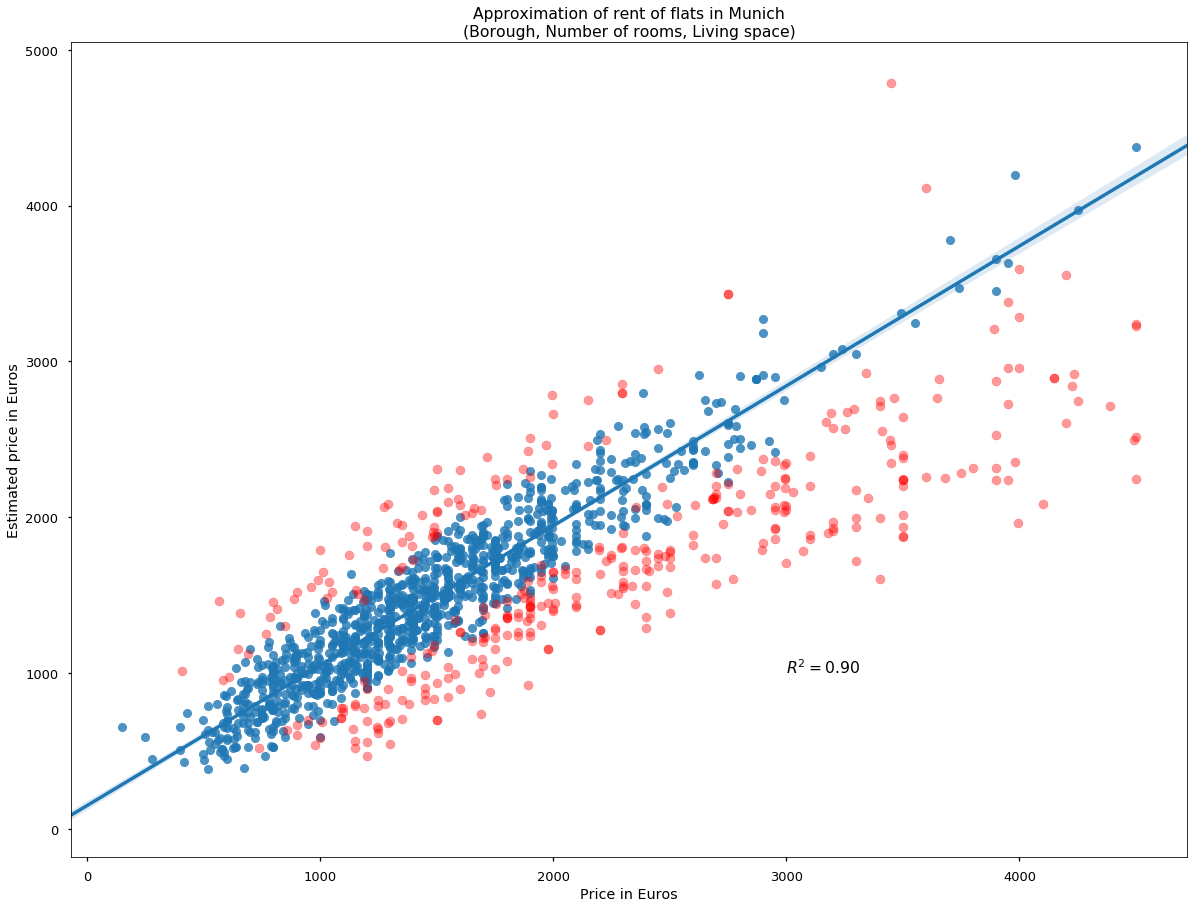

In [81]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
plt.subplots(figsize=(20,15))

sns.regplot(neighborhoods['price'][inlier_mask],
            neighborhoods['predicted_value'][inlier_mask])
plt.scatter(neighborhoods['price'][outlier_mask],
            neighborhoods['predicted_value'][outlier_mask],
            alpha=0.4,
            c='r')
plt.title('Approximation of rent of flats in Munich\n(Borough, Number of rooms, Living space)')
plt.xlabel('Price in Euros')
plt.ylabel('Estimated price in Euros')
plt.text(3000, 1000, r'$R^2=%.2f$' % r2_ransac)
plt.savefig('LinReg-Rent-Apartment.png', dpi=150)

Let's add another column to our neighborhoods dataframe called price_delta which reflects the distance from the actual price to the predicted price.  
If the price delta is negative, then it is a good price and we will recommend to rent this apartment.  
If it is negative, the recommendation will be not rent.

In [82]:
neighborhoods['price_delta'] = neighborhoods['price'] - neighborhoods['predicted_value']

In [83]:
neighborhoods

Borough  \
433                                      Schwabing-West   
251                                      Schwabing-West   
50                                       Altstadt-Lehel   
340                                      Schwabing-West   
701                               Neuhausen-Nymphenburg   
513                                       Au-Haidhausen   
802                               Milbertshofen-Am Hart   
223                                         Maxvorstadt   
1392                                Allach-Untermenzing   
754                                             Moosach   
1040                                 Ramersdorf-Perlach   
777                                             Moosach   
834                                         Bogenhausen   
217                                         Maxvorstadt   
1235  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
574                                   Sendling-Westpark   
1110                            Obergiesing-Fasangarten   
1060                                 Ramersdorf-Perlach   
49                                       Altstadt-Lehel   
978                                      Trudering-Riem   
215                                         Maxvorstadt   
88                         Ludwigsvorstadt-Isarvorstadt   
660                                    Schwanthalerhöhe   
781                                             Moosach   
762                                             Moosach   
778                                             Moosach   
751                                             Moosach   
524                                       Au-Haidhausen   
1090                            Obergiesing-Fasangarten   
1281                                             Hadern   
...                                                 ...   
1125                            Untergiesing-Harlaching   
189                                         Maxvorstadt   
408                                      Schwabing-West   
1145                            Untergiesing-Harlaching   
822                                         Bogenhausen   
53                         Ludwigsvorstadt-Isarvorstadt   
12                                       Altstadt-Lehel   
359                                      Schwabing-West   
64                         Ludwigsvorstadt-Isarvorstadt   
260                                      Schwabing-West   
253                                      Schwabing-West   
691                               Neuhausen-Nymphenburg   
690                               Neuhausen-Nymphenburg   
198                                         Maxvorstadt   
672                               Neuhausen-Nymphenburg   
171                                         Maxvorstadt   
148                                         Maxvorstadt   
708                               Neuhausen-Nymphenburg   
204                                         Maxvorstadt   
163                                         Maxvorstadt   
180                                         Maxvorstadt   
202                                         Maxvorstadt   
203                                         Maxvorstadt   
828                                         Bogenhausen   
8                                        Altstadt-Lehel   
274                                      Schwabing-West   
843                                         Bogenhausen   
34                                       Altstadt-Lehel   
142                                         Maxvorstadt   
236                                         Maxvorstadt   

                                           Neighborhood  Latitude_x  \
433   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
251   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
50    Graggenau , Angerviertel , Hackenviertel , Kre...   48.143054   
340   Neuschwabing , Am Luitpoldpark , Schwere-Reite...   48.167852   
701   Neuhausen , Nymphenburg , Ob

In [84]:
best_apt = neighborhoods.sort_values('price_delta')
best_apt

Borough  \
681                               Neuhausen-Nymphenburg   
660                                    Schwanthalerhöhe   
673                               Neuhausen-Nymphenburg   
743                                             Moosach   
536                                            Sendling   
1181  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
771                                             Moosach   
1343                         Aubing-Lochhausen-Langwied   
502                                       Au-Haidhausen   
1410                             Feldmoching-Hasenbergl   
1427                                               Laim   
547                                            Sendling   
1182  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
1186  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
1415                             Feldmoching-Hasenbergl   
604                                   Sendling-Westpark   
779                                             Moosach   
169                                         Maxvorstadt   
1414                             Feldmoching-Hasenbergl   
553                                            Sendling   
472                                       Au-Haidhausen   
1409                             Feldmoching-Hasenbergl   
740                                             Moosach   
1322                         Aubing-Lochhausen-Langwied   
954                                        Berg am Laim   
513                                       Au-Haidhausen   
450                                       Au-Haidhausen   
458                                       Au-Haidhausen   
744                                             Moosach   
1413                             Feldmoching-Hasenbergl   
...                                                 ...   
422                                      Schwabing-West   
62                         Ludwigsvorstadt-Isarvorstadt   
253                                      Schwabing-West   
707                               Neuhausen-Nymphenburg   
18                                       Altstadt-Lehel   
796                               Milbertshofen-Am Hart   
895                                         Bogenhausen   
204                                         Maxvorstadt   
299                                      Schwabing-West   
1145                            Untergiesing-Harlaching   
1229  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
274                                      Schwabing-West   
852                                         Bogenhausen   
203                                         Maxvorstadt   
202                                         Maxvorstadt   
180                                         Maxvorstadt   
163                                         Maxvorstadt   
828                                         Bogenhausen   
12                                       Altstadt-Lehel   
822                                         Bogenhausen   
46                                       Altstadt-Lehel   
149                                         Maxvorstadt   
359                                      Schwabing-West   
8                                        Altstadt-Lehel   
34                                       Altstadt-Lehel   
148                                         Maxvorstadt   
672                               Neuhausen-Nymphenburg   
843                                         Bogenhausen   
236                                         Maxvorstadt   
142                                         Maxvorstadt   

                                           Neighborhood  Latitude_x  \
681   Neuhausen , Nymphenburg , Oberwiesenfeld , St....   48.155115   
660                         Westend , Schwanthalerhöhe    48.135962   
673   Neuhausen , Nymphenburg , Oberwiesenfeld , St....   48.155115   
743                      Alt Moosach , Moosach-Bahnhof    48.181108   
536                    Untersendli

### Discussion
Remember, how we wanted to find the best apartment in the boroughs Hadern, Laim, Milbertshofen-Am Hart and Sendling-Westpark?  
It seems like the apartment with index **605** and a price_delta of -674 seems to be it!  
Let's see what the landlord has to say.  

### Data visualization
But before, let's put all these data points on a map:

In [85]:
best_apt['buy'] = best_apt['price_delta'] < 0
neighborhoods['buy'] = neighborhoods['price_delta'] < 0
best_apt

Borough  \
681                               Neuhausen-Nymphenburg   
660                                    Schwanthalerhöhe   
673                               Neuhausen-Nymphenburg   
743                                             Moosach   
536                                            Sendling   
1181  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
771                                             Moosach   
1343                         Aubing-Lochhausen-Langwied   
502                                       Au-Haidhausen   
1410                             Feldmoching-Hasenbergl   
1427                                               Laim   
547                                            Sendling   
1182  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
1186  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
1415                             Feldmoching-Hasenbergl   
604                                   Sendling-Westpark   
779                                             Moosach   
169                                         Maxvorstadt   
1414                             Feldmoching-Hasenbergl   
553                                            Sendling   
472                                       Au-Haidhausen   
1409                             Feldmoching-Hasenbergl   
740                                             Moosach   
1322                         Aubing-Lochhausen-Langwied   
954                                        Berg am Laim   
513                                       Au-Haidhausen   
450                                       Au-Haidhausen   
458                                       Au-Haidhausen   
744                                             Moosach   
1413                             Feldmoching-Hasenbergl   
...                                                 ...   
422                                      Schwabing-West   
62                         Ludwigsvorstadt-Isarvorstadt   
253                                      Schwabing-West   
707                               Neuhausen-Nymphenburg   
18                                       Altstadt-Lehel   
796                               Milbertshofen-Am Hart   
895                                         Bogenhausen   
204                                         Maxvorstadt   
299                                      Schwabing-West   
1145                            Untergiesing-Harlaching   
1229  Thalkirchen-Obersendling-Forstenried-Fürstenri...   
274                                      Schwabing-West   
852                                         Bogenhausen   
203                                         Maxvorstadt   
202                                         Maxvorstadt   
180                                         Maxvorstadt   
163                                         Maxvorstadt   
828                                         Bogenhausen   
12                                       Altstadt-Lehel   
822                                         Bogenhausen   
46                                       Altstadt-Lehel   
149                                         Maxvorstadt   
359                                      Schwabing-West   
8                                        Altstadt-Lehel   
34                                       Altstadt-Lehel   
148                                         Maxvorstadt   
672                               Neuhausen-Nymphenburg   
843                                         Bogenhausen   
236                                         Maxvorstadt   
142                                         Maxvorstadt   

                                           Neighborhood  Latitude_x  \
681   Neuhausen , Nymphenburg , Oberwiesenfeld , St....   48.155115   
660                         Westend , Schwanthalerhöhe    48.135962   
673   Neuhausen , Nymphenburg , Oberwiesenfeld , St....   48.155115   
743                      Alt Moosach , Moosach-Bahnhof    48.181108   
536                    Untersendli

In [86]:
#!conda install -c conda-forge folium=0.5.0 --yes
import branca
import folium # map rendering library

# create map of New York using latitude and longitude values
map_munich2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for url, lat, lng, borough, price, livingSpace, numberOfRooms, predicted_value, buy in zip(neighborhoods['url'], neighborhoods['Latitude_y'], neighborhoods['Longitude_y'], neighborhoods['Borough'], neighborhoods['price'], neighborhoods['livingSpace'], neighborhoods['numberOfRooms'], neighborhoods['predicted_value'], neighborhoods['buy']):
    label = "<a href='{}'target='_blank'>Apartment in {}</a> <br> Actual price: {} € <br> Square meters: {} <br> Rooms: {} <br> Predicted price: {} € <br> Buy: {}".format(url, borough, int(price), int(livingSpace), int(numberOfRooms), int(predicted_value), buy)
    iframe = branca.element.IFrame(html=label, width=200, height=200)
    label = folium.Popup(iframe,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_munich2)  
    
map_munich2

## Conclusion
In summary, I was looking up all boroughs in Munich.  
With these boroughs, I checked the most common venue category for each with the Foursquare API.  
As a personal preference, I wanted to have supermarket and public transport access as my most common venue category.  
Several suitable boroughs have been selected.

Afterwards, I scraped all available apartments in Munich from the biggest rental platform.  
I did some descriptive statistics on those to find the average monthly rent price of 1742 euros with 2.6 rooms.  
After building a regression model with the RANSAC method, I predicted the prices for apartments regarding the characteristics living space, number of rooms and boroughs.  (multi-linear regression)  
All this data has been displayed on a folium map.  
As a choice of presentation, I put this onto my website too: www.greenvegan.de  
Finally, I calculated the difference of the actual monthly rental price and the predicted price and looked for the apartment with the biggest delta in my pre-selected boroughs.  
An apartment in Sendling-Westpark with the ID 605 has been selected as the "best" apartment.